In [20]:
# coding: utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import matplotlib.pyplot as plt
import scipy.integrate as sci_integrate
import time
import sys
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
from scipy.misc import derivative

#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


'''vac model from cutler94'''


def phi(f,m1,m2,phic,tc):
    x=np.power(sciconsts.pi*(m1+m2)*f,2.0/3.0)
    mc=chirp_mass(m1,m2)
    a=0.75*np.power(8*sciconsts.pi*mc*f,-5.0/3.0)*(1+20.0/9.0*(743.0/336.0+11.0*m1*m2/(m1+m2)/(m1+m2)/4.0)*x-16.0*sciconsts.pi*np.power(x,1.5))
    return a-phic+2*sciconsts.pi*f*tc-0.25*sciconsts.pi

def hf(f,m1,m2,d,phic):
    mc=chirp_mass(m1,m2)
    phi=phi(f,m1,m2,phic)
    return mc/d*np.power(f,-7.0/6.0)*np.exp(1.0j*1.0)


'''my T model(considering gas (geo unit)'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)*t_gas+np.power(a_0,4.0))
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1*t_gas),0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2))*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)
# In[34]:

'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    return np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)*sciconsts.G/np.power(sciconsts.c,2.0)
    return np.sqrt(sciconsts.G)/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(sciconsts.G*M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''f model gas '''
def df_dtgas(f,m1,m2,tgas):
    mu=m1*m2/(m1+m2)
    M=m1+m2
    return np.power(f,11.0/8.0)*np.power(sciconsts.pi,3.0/8.0)/np.power(M,3.0/16.0)*32.0/3.0/tgas*(np.power(sciconsts.pi*f/np.sqrt(M),-3.0/8.0)+64.0/5.0*mu*M*M)


def hgas_amp(f,m1,m2,tgas):
    mu1=m1*m2/(m1+m2)
    M1=m1+m2
    return mu1*M1*np.power(sciconsts.pi*f/np.sqrt(M1),2.0/3.0)/np.power(df_dtgas(f,m1,m2,tgas),0.5)
'''find max1 related function'''  
def df_dtode(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    result=np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
    return result  

SyntaxError: invalid syntax (<ipython-input-20-766e78367cb0>, line 87)

In [16]:
#consts setting
#c=G=1 unit [s]
sivalue=0.125
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
pc=3.261*sciconsts.light_year
t_scale=4*years*sivalue


# In[37]:

#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval,Aerr

(2.6333286072614928e-107, 1.4617910255929026e-121)

In [3]:
t_gas

31536000000.0

In [17]:
f=np.linspace(1e-3,1e-2,10000)
hfg2=hgas_amp(f,m_1g,m_2g,t_gas)
hfg1=hs(f)

In [18]:
hfg2

array([ 0.00193845,  0.00193874,  0.00193903, ...,  0.00284518,
        0.00284522,  0.00284526])

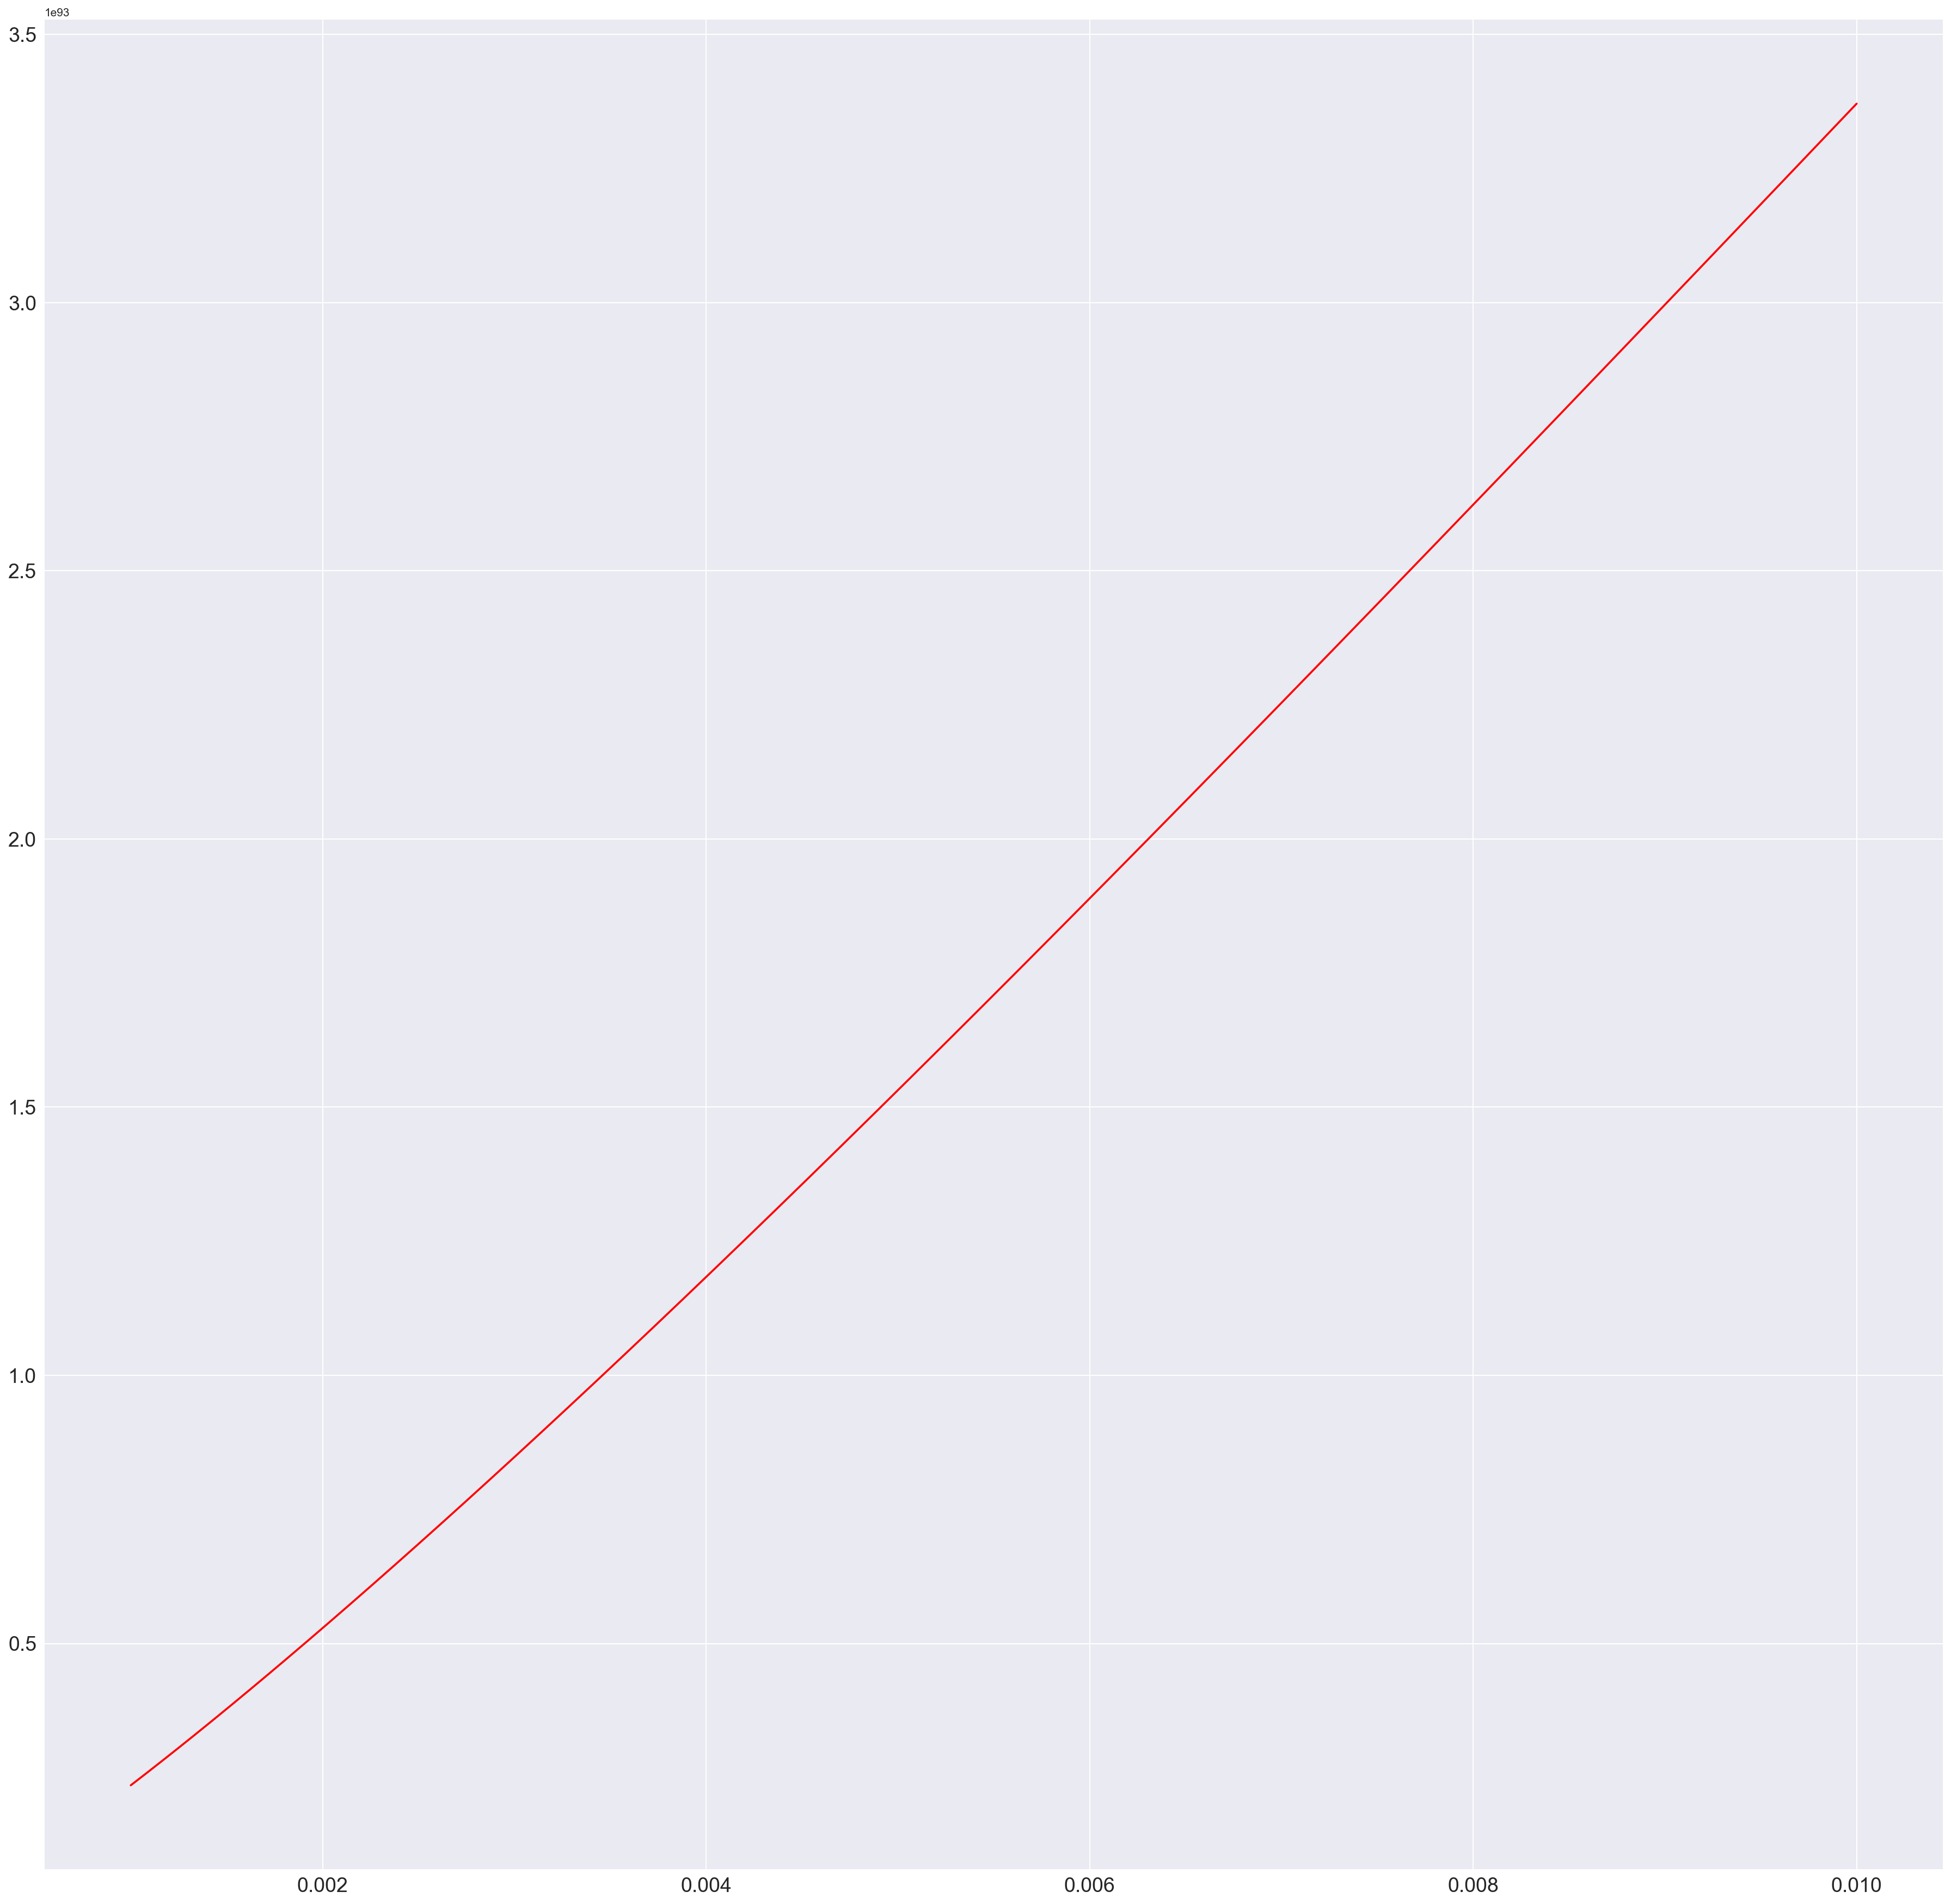

In [19]:
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(f,hfg2/hfg1,color='red')
#plt.xscale('log')
plt.show()

In [88]:
a=hfg2/hfg1

In [92]:
hfg2.min()

2.4266116064301122e-22

In [14]:
'''vac model fittness'''
m1v=10.0*m_sun
m2v=10.0*m_sun
n2=10000
ts=np.linspace(0,t_scale,n2)
yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
ftv=sci_interpolate.interp1d(ts,yf.T[0])
fr=ftv(ts)
phiv1=np.zeros(n2)
i=0
while i<n2:
    phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
    i=i+1
phiv=sci_interpolate.interp1d(ts,phiv1)

rs=np.zeros(n2)
rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])

for i in range(1,n2,1):
    rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])

rv=sci_interpolate.interp1d(ts,rs)

t_scalev=ts[n2-1]
t=np.linspace(0,t_scalev,num=Ng)
hv=m1v*m2v/rv(t)*np.cos(phiv(t))/1e70
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(hv)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hvacr=sci_interpolate.interp1d(xs,hfvac2)
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
Bval=np.sqrt(B[0])
Berr=0.5/Bval*B[1]



/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
ffgas

5.0190274363217167e-21

In [9]:
# In[78]:



def find_max2(m):
    mcv=m[0]*m_sun
    smrv=m[1]
    figas=m[2]
    ffgas=m[3]
    sv=solvem(mcv,smrv)
    m1v=sv[0]
    m2v=sv[1]
    n2=10000
    ts=np.linspace(0,t_scale,n2)
    yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
    ftv=sci_interpolate.interp1d(ts,yf.T[0])
    fr=ftv(ts)
    phiv1=np.zeros(n2)
    i=0
    while i<n2:
        phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
        i=i+1
    phiv=sci_interpolate.interp1d(ts,phiv1)
    
    rs=np.zeros(n2)
    rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])
    
    for i in range(1,n2,1):
        rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])
    
    rv=sci_interpolate.interp1d(ts,rs)
    
    t_scalev=ts[n2-1]
    t=np.linspace(0,t_scalev,num=Ng)
    hv=m1v*m2v/rv(t)*np.cos(phiv(t))/1e70
    xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
    hfvac1=fft.fft(hv)
    hfvac_abs=abs(hfvac1)
    hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
    hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
    hvacr=sci_interpolate.interp1d(xs,hfvac2)
    anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
    B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
    Bval=np.sqrt(B[0])
    Berr=0.5/Bval*B[1]
    #phi max finding
    phinum=100
    phics=np.linspace(0,2*sciconsts.pi,phinum)
    ffmax=0
    errmax=0
    phimaxpos=0
    for phic in phics:
        AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
        ff=abs(AB[0]/Aval/Bval)
        err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
        #err1=abs(1*AB[1]/AB[0])+abs(1.0/Aval*Aerr)+abs(1.0/Bval*Berr)
        if ff>ffmax:
            ffmax=ff
            errmax=err
            phimaxpos=phic
    print ffmax,errmax,m[0],m[1],phimaxpos
    sys.stdout.flush()
    return ffmax,errmax,m[0],m[1],phimaxpos


# In[ ]:

a=time.time()
pool = Pool(20)
results = []
tasknum=int(sys.argv[1])
#tasknum from 0-9 for 10nodes，20cpus in every node（pkuhpc system cn-short）
mci=float(sys.argv[2])
mcf=float(sys.argv[3])
corenum=int(sys.argv[4])
n3=600
ns=100
nc=n3/ns
del_mc=(mcf-mci)/nc/corenum
mcii=mci+nc*tasknum*del_mc
mcff=mcii+del_mc*nc
m_cs=np.linspace(mcii,mcff,int(nc))
smrs=np.linspace(0.24,0.25,int(ns))
m_cs2=np.zeros(int(n3))
smrs2=np.zeros(int(n3))
for i in range(0,nc):
    for j in range(0,ns):
        m_cs2[i*ns+j]=m_cs[i]
        smrs2[i*ns+j]=smrs[j]
f1=np.zeros(int(n3))+figas
f2=np.zeros(int(n3))+ffgas
para=[m_cs2,smrs2,f1,f2]
para1=np.transpose(para)
results = pool.map(find_max2, para1)
b=time.time()
pool.close()
pool.join()
b=time.time()
print 'processes done, :',b-a,'seconds used'
sys.stdout.flush()
fname='f %s-%s'%(mcii,mcff)
np.save(fname,results)

ValueError: invalid literal for int() with base 10: '-f'

In [34]:
sciconsts.parsec/sciconsts.light_year

3.261563776971214

In [50]:
M=1
m=0

In [51]:
M

1